# Table of Contents


[Definition of Utility Functions](#util_func) <br/>
[Faster R-CNN Implementation](#fasterRCNN): <br/>
- [Baseline Implementation](#fasterRCNN_baseline) <br/>
- [Custom anchor sizes](#custom_anchor) <br/>

<br/><br/>
[YOLOv11 Implementation](#YOLOv11): <br/>
[Appendix A](#AppenA): <br/>

remember: First Bullet Header <a class="anchor" name="first-bullet"></a>

In [1]:
#set up github

Cloning into 'Object-Detection-Neural-Networks'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 36 (delta 14), reused 23 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 8.61 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (14/14), done.


## Definition of Utility Functions: <a class="anchor" name="util_func"></a>

In [ ]:
import shutil

# !git pull
# !git status

#check remotes
#!git remote -v


def git_push(message, branch):
  #move to git repo before using git commands
  %cd '/content/Object-Detection-Neural-Networks'

  #copy current notebook to cloned git repo
  file_to_copy = '/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/UoL Final Project based on CM3015 template "deep learning on public dataset".ipynb'
  git_repo = '/content/Object-Detection-Neural-Networks'

  #overwrite the file in the local cloned github repo
  shutil.copy(file_to_copy, git_repo)

  !git add 'UoL Final Project based on CM3015 template "deep learning on public dataset".ipynb'

  !git commit -a -m "{message}"
  !git push origin "{branch}"

def publish_branch(branch):
  %cd '/content/Object-Detection-Neural-Networks'
  !git push -u origin "{branch}"

def create_branch(branch):
  %cd '/content/Object-Detection-Neural-Networks'
  !git checkout -b "{branch}"

In [ ]:
%cd '/content/Object-Detection-Neural-Networks'
!git branch

/content/Object-Detection-Neural-Networks
  main
* training_func


In [ ]:
#CURRENT BRANCH
%cd '/content/Object-Detection-Neural-Networks'
!git switch "training_func"

/content/Object-Detection-Neural-Networks
Branch 'training_func' set up to track remote branch 'training_func' from 'origin'.
Switched to a new branch 'training_func'


In [ ]:
# git_push("Refactor training functions for model and add docstrings", "training_func")

/content/Object-Detection-Neural-Networks
[training_func cf83f6e] Refactor training functions for model and add docstrings
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite "UoL Final Project based on CM3015 template \"deep learning on public dataset\".ipynb" (96%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 12 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 88.95 KiB | 9.88 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/Amy-RT/Object-Detection-Neural-Networks
   9205a7f..cf83f6e  training_func -> training_func


In [ ]:
import random
import numpy as np
import torch

#print(torch.__version__)
device = torch.device("cuda:0")
print(device)

#the google style guide suggest that a docstring is not necessary for the set_seeds() function
#as it does not meet any of the following critera
#A docstring is mandatory for every function that has one or more of the following properties:
  # - being part of the public API
  # - nontrivial size
  # - non-obvious logic
#https://github.com/google/styleguide/blob/gh-pages/pyguide.md#38-comments-and-docstrings

#THE SET_SEEDS FUNCTION IS SOURCED FROM:
#https://learnopencv.com/fine-tuning-faster-r-cnn/#aioseo-code-walkthrough
def set_seeds():
  # fix random seeds
  SEED_VALUE = 42
  random.seed(SEED_VALUE)
  np.random. seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)
  if torch.cuda.is_available:
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seeds()

cuda:0


In [ ]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time

#as a utility function to ensure each iteration of Faster R-CNN is trained in the same way
#ie keep the training procedure as a control

#CONTINUE WATCHING THIS VIDEO
#https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
def train_model(num_epochs: int,
                train_dataset: torch.utils.data.DataLoader,
                model: torchvision.models.detection,
                optimizer: torch.optim) -> None:
  """Trains the model for the specified number of epochs

    Calls function train_batch to train the model on each batch in an epoch.
    Training time is recorded for the purposes of evaluation.
    Epoch loss is calculates as the average of

    Args:
        num_epochs: the number of epochs to train for,

        train_dataset: the PyTorch DataLoader for the training set

        model: the instance of the PyTorch model

        optimizer : any optimizer imported from torch.optim

    Returns:
        None

    Raises:
        None
    """
  start_time = time.time()
  training_losses = []
  for epoch in range(num_epochs):
      epoch_loss = 0
      for batch in train_dataset:
        batch_loss = train_batch(batch, model, optimizer)
        epoch_loss += batch_loss
      # divide total epoch loss by the total number of batches per epoch
      training_losses.append(epoch_loss/len(train_dataset))


  end_time = time.time()
  execution_time = end_time - start_time
  print(f'Training time: {execution_time} seconds')
  plot_loss([i+1 for i in range(num_epochs)], training_losses)

          #memory management
          # images = [ t.cpu() for t in images]
          # targets = [ {'boxes':d['boxes'].cpu(), 'labels':d['labels'].cpu()} for d in targets]
          # del images
          # del targets

In [ ]:
def train_batch(batch: torch.utils.data.dataset.Subset,
                model: torchvision.models.detection,
                optimizer: torch.optim) -> float:
  """Trains the model on a single batch and returns the batch loss

    Calls function format_batch() before training the model on the batch data.
    Total loss is calculated across each of the 4 losses returned by Faster R-CNN
    A backward pass is then completed

    Args:
        batch: a subset of the PyTorch dataset

        model: the instance of the PyTorch model

        optimizer : any optimizer imported from torch.optim

    Returns:
        batch loss

    Raises:
        None
    """
  data_dict = format_batch(batch, model)
  images, targets = data_dict['images'], data_dict['targets']

  loss_dict = model(images, targets)
  #IS THIS APPROACH COMPARABLE TO LOSS CALCULATION IN YOLO?
  #IN ORDER TO MAKE COMPARISONS BETWEEN ARCHITECTURES
  loss = sum(v for v in loss_dict.values())
  print(loss)
  # backward pass
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.item()
  #TO DO: CALCULATE mAP FOR EACH EPOCH ?
  # is this avg calc correct ?
  # https://datascience.stackexchange.com/questions/92673/should-i-report-loss-on-the-last-batch-or-the-entire-training-dataset

In [ ]:
def format_batch(batch: torch.utils.data.dataset.Subset ,
                 model: torchvision.models.detection) -> dict:
  """Formats batch for processing on GPU

    Checks all images and targets are in tensor form ready for training.
    Also moves all images and targets to the same device as the model ready for processing

    Args:
        batch: a subset of the PyTorch dataset

        model: used to determine which device the batch data should be sent to

    Returns:
        dictionary of prepared batch data ; has 2 keys 'images and targets'

    Raises:
        None
    """

  images = []
  targets = []
  device = next(model.parameters()).device

  for img, targets_dict in batch:
      images.append(img)
      #target boxes expected to be of type Tensor
      targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
      targets_dict['labels'] = torch.tensor(targets_dict['labels'])

      # Data type conversions required by Mac GPU 'MPS'
      #format to tensor of dtype float 32 as supported by MPS
      # targets_dict['boxes'] = targets_dict['boxes'].type(torch.float32)
      # targets_dict['labels'] = targets_dict['labels'].type(torch.int64)

      targets.append(targets_dict)

  #move relevant data to GPU
  #otherwise error: RuntimeError: Mismatched Tensor types in NNPack convolutionOutput
  images = [ t.to(device) for t in images]
  targets = [ {'boxes':d['boxes'].to(device), 'labels':d['labels'].to(device)} for d in targets]

  return {'images': images, 'targets': targets}

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def visualisePredictions(img_id: int,
                         test_dataset: torch.utils.data.dataset.Subset,
                         predicted: list) -> None:

  """Visualises model predictions (bounding boxes) on top of the corresponding image

    Retrieves the original image from the test set and plots bouning boxes onto the image.
    Each classes is represented by a different colour bounding box.

    Args:
        img_id: the number of the image within the batch,

        test_dataset: Subset of PyTorch dataset ; each item in the array is a tuple consisting of
        a tensor representing the image and a dictionary containing 'boxes' and 'labels' keys,

        precicted: array of model predictions for set of images ; the array consists of
        dictionaries each with 2 keys: boxes and labels

    Returns:
        No value returned ; only plt.show()

    Raises:
        IndexError: An error occurred accessing the image at the specified index.
    """

  try:
    img = test_dataset[img_id][0].permute(1,2,0)
    predictions = predicted[img_id]

    fig, ax = plt.subplots()
    ax.imshow(img)

    for (index, box) in enumerate(predictions['boxes']):
      #move data from GPU to CPU ready for visualisation
      cpu_box = box.cpu()
      predicted_label = predictions['labels'][index]

      #class names: ['migrating_single', 'plastic', 'water_hyacinth']
      colour_mappings = ['y', 'white', 'orange']
      #draw bounding box
      try:
        bbox = patches.Rectangle((cpu_box[0], cpu_box[1]), cpu_box[2], cpu_box[3], linewidth=1, edgecolor=colour_mappings[predicted_label], facecolor='none')
      except IndexError:
        print("Bounding box does not have 4 coordinates")
        print(cpu_box)
        raise

      # Add the patch to the Axes
      ax.add_patch(bbox)
    plt.show()

  except IndexError:
      print(f'Provided dataset is of length {len(test_dataset)} - image index {img_id} not within range')
      raise


In [ ]:
##THE CODE IN THIS CELL HAS BEEN MODIFIED FROM SOURCE:
#https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch
#the majority of this function is composed of PyTorch source code that has been slightly modififed so that both losses and predictions are returned during inference
#PyTorch source files (which part of code was sourced from) can be seen here
#https://github.com/pytorch/vision/blob/f40c8df02c197d1a9e194210e40dee0e6a6cb1c3/torchvision/models/detection/generalized_rcnn.py#L46

#analyse using this reference
#https://stackoverflow.com/questions/60339336/validation-loss-for-pytorch-faster-rcnn
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    #Added (generalized_rcnn.py forward())
    model.eval()

    #*******************************START:Sourced from generalized_rcnn.py forward()
    # lines 72-98 of generalized_rcnn.py
    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    #*******************************END:Sourced from generalized_rcnn.py forward()

    # MODIFICATION: COMMENTED OUT THESE LINES OF CODE
    # AS RPN AND ROI DO NOT NEED TO BE TRAINING DURING INFERENCE ?
    # model.rpn.training=True
    # model.roi_heads.training=True
    # END OF MODIFICATION


    # ************Following section of code implements similar functionality to:
    # proposals, proposal_losses = model.rpn(images, features, targets)
    # from generalized_rcnn.py forward():
    # Code relating to the RPN (Region Proposal Network)
    #*******************************START:Sourced from rpn.py
    #lines 325-340 in rpn.py
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # Following 3 lines are comments from PyTorch source code
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)
    proposal_losses = {}

    #lines 342-351 in rpn.py
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }
    #*******************************END:Sourced from rpn.py

    #image size required by ROI head
    image_shapes = images.image_sizes

    # ************Following section of code implements similar functionality to:
    #detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    # from generalized_rcnn.py forward():
    # Code relating to the ROI heads (Region of Interest)
    #*******************************START:Sourced from roi_heads.py
    # lines 745-771 of roi_heads.py
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)

    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}

    # The following 2 lines of code were original inside a 'if self.training' condition
    # they have been taken out of this if statment so that
    # losses can be returned when in inference mode (to get val loss)
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}

    # the code below was the corresponding 'else' statement (ie if not self.training)
    # it was taken out if the else statement
    # so that both predictions and losses could be returned when in inference mode
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    #*******************************END:Sourced from roi_heads.py

    # rename results as detection so that it is compatible with the subsequent
    # line of code sourced from generalized_rcnn.py
    detections = result
    # Following line of code sourced from generalized_rcnn.py (line 100)
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]

    # MODIFICATION: REMOVED THE FOLLOWING 2 LINES OF CODE
    # model.rpn.training=False
    # model.roi_heads.training=False

    #*******************************START:Sourced from generalized_rcnn.py forward()
    # lines 102-104 in generalized_rcnn.py
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    #*******************************END:Sourced from generalized_rcnn.py forward()

    #Added (generalized_rcnn.py forward())
    return losses, detections

In [ ]:
#Function 'evaluate_loss' is modified from source:
#https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch
#A docstring has been added for the modified function

def evaluate_loss(model, data_loader, device):
  #ballpark type of model
  #'torchvision.models.detection.faster_rcnn.FasterRCNN'

    """Calculates average validation loss across batches in a PyTorch DataLoader

    Calls function eval_forward() to caluclate validation loss for each batch.
    Each batch validation loss is added to a running total which is divided by the
    number of batches to get average validation loss across batches.

    Args:
        model: the PyTorch model which has been trained

        data_loader: a Pytorch DataLoader

        device: the device which the model is currently stored on (usually GPU)

    Returns:
        The average validation loss across batches

    Raises:
        AssertionError: If validation data is assigned a different device to model
    """

    #*************************************START OF MODIFICATION 1
    #model and validation data must be on same device in order to
    #calculate validation loss
    assert next(model.parameters()).device == device, "Validation data and model must be assigned to the same device"
    #*************************************START OF MODIFICATION 1

    val_loss = 0
    with torch.no_grad():
      for batch in data_loader:
        #*************************************START OF MODIFICATIONS 2
        images = []
        targets = []
        #gather imgs and targets in separate arrays for each batch
        #ready to calculate validation loss for each batch
        for img, targets_dict in batch:
            images.append(img)

            #following code only required if using MPS for Mac GPU
            # #format to tensor of dtype float 32 as supported by MPS
            # targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
            # targets_dict['boxes'] = targets_dict['boxes'].type(torch.float32)
            # #targets_dict['boxes'] =targets_dict['boxes'].to(device)

            # targets_dict['labels'] = torch.tensor(targets_dict['labels'])
            # targets_dict['labels'] = targets_dict['labels'].type(torch.int64)
            # #targets_dict['labels'] =targets_dict['labels'].to(device)


            targets.append(targets_dict)

        #move validation dataset to the same device that the model is on
        images = [ t.to(device) for t in images]
        targets = [ {'boxes':d['boxes'].to(device), 'labels':d['labels'].to(device)} for d in targets]
        #*************************************END OF MODIFICATIONS 2
        losses_dict, detections = eval_forward(model, images, targets)
        losses = sum(loss for loss in losses_dict.values())
        val_loss += losses

    validation_loss = val_loss/ len(data_loader)
    return validation_loss

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(epochs, losses):
  # cpu_epochs = Tensor.cpu(epochs)
  # cpu_losses = losses
  # plt.scatter([ t.cpu() for t in epochs], [ t.cpu() for t in losses])
  #plt.scatter(cpu_epochs, cpu_val_loss)

  plt.xlabel("Epochs")
  plt.ylabel("Average loss across batches")
  plt.plot(epochs, losses)

  plt.show()

## Faster R-CNN Implementation: <a class="anchor" name="fasterRCNN"></a>

### Base line Implementation: <a class="anchor" name="fasterRCNN_baseline"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train'
image_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train/images'
label_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train/labels'

In [ ]:
import os
import torch
from torchvision import transforms

from PIL import Image
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

In [ ]:
from torch.utils.data import Dataset
import numpy as np

class UAVImageDataset(Dataset):
    """Overrides the PyTorch Dataset class

      Defines how raw data should be read and transformed ready for model training

      Attributes:
          data_dir_imgs: file string path to raw images
          data_dir_targets: file string path to raw target data
          imgs: the formatted images ready for training
          targets: the formatted targets ready for training
    """

    def __init__(self, data_dir_imgs: str, data_dir_targets: str, transform=None) -> None:
        """Formats the raw images and targets ready for model training

          Images are converted to tensors as required by PyTorch for model training
          All tensor representations of images are stored in a List
          Targets (boxes and labels) are compiled into a dictionary for each image
          All targets are stored in a list
          An image and it's targets are stored at the same index in their respective arrays

        Args:
          data_dir_imgs: a string representing the file path to the image folder of the dataset
          data_dir_targets: a string representing the file path to the 'targets' folder of the dataset
        """

        self.data_dir_imgs = data_dir_imgs
        self.data_dir_targets = data_dir_targets
        self.transforms = transforms

        file_names = os.listdir(path=data_dir_imgs)
        number_of_images = len(file_names)

        self.imgs = []
        self.targets = []

        for i in range(number_of_images):
            img = data_dir_imgs + '/'+ file_names[i]
            img_read = cv2.imread(img)
            image_transform = transforms.ToTensor()  #cv library reads as a numpy array, needs to be a pytorch tensor to be compatible
            img = image_transform(img_read)
            self.imgs.append(img)

            #remove .jpg or .png file extension and retrieve corresponding labels
            with open(data_dir_targets + '/' + file_names[i][:-4]+ '.txt','r') as f:
                file_lines = f.read().splitlines()

                targets = {
                        "boxes": [],
                        "labels": []
                    }

                #.txt label files with no annotations cause training error;
                if len(file_lines) ==0:
                    #follow 2 lines of code sourced from:
                    #https://discuss.pytorch.org/t/fasterrcnn-images-with-no-objects-present-cause-an-error/117974/13
                    #to address the issue of images with no ground truth bounding boxes
                    targets["boxes"] = torch.as_tensor(np.array(np.zeros((0, 4)), dtype=float))
                    targets["labels"] = torch.as_tensor(np.array([], dtype=int), dtype=torch.int64)
                else:
                    for file_line in file_lines:
                        indiv_items = file_line.split(" ")
                        label, x1, y1, width, height = indiv_items[0], indiv_items[1], indiv_items[2], indiv_items[3], indiv_items[4]
                        label = int(label)
                        x1, width,  = float(x1)*img_read.shape[1], float(width)*img_read.shape[1],
                        y1, height = float(y1)*img_read.shape[0], float(height)*img_read.shape[0]
                        x2 = x1 + width
                        y2 = y1 + height

                        #ADD TRY EXCEPT CLAUSE HERE
                        if x2 < x1 or x1 == x2 or y2 < y1 or y1 == y2:
                            print('Invalid Ground Truth Bounding Box')
                            print(x1, y1, x2, y2)

                        #YOLO label format is x-centre, y-centre, width, height
                        targets['boxes'].append([x1-width/2, y1-height/2, x2-width/2, y2-height/2])
                        targets['labels'].append(label)

                self.targets.append(targets)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.targets[idx]

In [ ]:
dataset = UAVImageDataset(data_dir_imgs=image_folder_path, data_dir_targets=label_folder_path)

In [ ]:
from torch.utils.data import random_split

#TO DO: MULTIPLE VALIDATION SETS ?
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
# train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])

In [ ]:
#VISUALISE DATA AS SANITY CHECK

In [ ]:
#set shuffle to True so that the training of the model is not dependent on the order of the data
#only have shuffle=False for validation/testing and inference
train_dataset = torch.utils.data.DataLoader(train_dataset, collate_fn=lambda x: x, batch_size=16, shuffle=True, pin_memory=True)
# val_dataset_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=lambda x: x, batch_size=16)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, collate_fn=lambda x: x, batch_size=16)

In [ ]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #- 0.1568 mAP50
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True) - 0.1080 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True) - 0.0434 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True) - 0.0161 mAP50

#needs separate fine tuning process for this model
#model = torchvision.models.detection.ssd300_vgg16(pretrained=True)


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

num_classes = 4  #+1 for background - there are 3 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
#Must move model (and it's parameters) to the GPU before initialisating the optimizer
#according to a video on the official PyTorch Youtube Channel
#https://www.youtube.com/watch?v=jF43_wj_DCQ&t=213s
#otherwise the optimiser will update the wrong set of model parameters (on the CPU)
model.to(device)
optimizer = torch.optim.SGD(model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)
num_epochs = 15

<ipython-input-9-802f11b11e5f>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
<ipython-input-9-802f11b11e5f>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['labels'] = torch.tensor(targets_dict['labels'])


tensor(3.5076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.7957, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2621, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8515, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7260, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3915, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3608, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0481, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8070, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1738, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4505, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7692, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8300, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9296, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1155, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2933, device='cuda:0', grad_fn=<AddBack

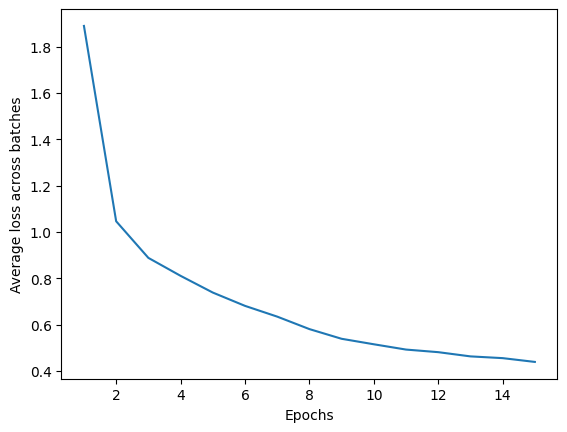

In [ ]:
train_model(num_epochs, train_dataset, model, optimizer)

In [ ]:
#evaluate on test set - only give image to model
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.empty_cache()

images = []
targets = []
for batch in test_dataset_loader:
    for img, targets_dict in batch:
        #img = img.to(device)
        images.append(img)


        #format to tensor of dtype float 32 as supported by MPS
        targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])

        #targets_dict['boxes'] =targets_dict['boxes'].to(device)

        targets_dict['labels'] = torch.tensor(targets_dict['labels'])

        #targets_dict['labels'] =targets_dict['labels'].to(device)

        # Data type conversions required by Mac GPU 'MPS'
        # targets_dict['boxes'] = targets_dict['boxes'].type(torch.float32)
        # targets_dict['labels'] = targets_dict['labels'].type(torch.int64)


        targets.append(targets_dict)


images = [ t.to(device) for t in images]
targets = [ {'boxes':d['boxes'].to(device), 'labels':d['labels'].to(device)} for d in targets]

#reduce memory usage by not storing intermediate tensors needed to calculate gradients
#torch.no_grad reportedly speeds up computations
with torch.no_grad():
  predicted = model(images)

<ipython-input-26-8e2a60fc8e83>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['boxes'] = torch.tensor(targets_dict['boxes'])
<ipython-input-26-8e2a60fc8e83>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_dict['labels'] = torch.tensor(targets_dict['labels'])


In [ ]:
evaluate_loss(model, test_dataset_loader, device)

tensor(0.3584, device='cuda:0')

In [ ]:
!pip install torchmetrics
!pip install faster-coco-eval
!pip install pycocotools
#https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html

from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5, 0.75], class_metrics=True)

for pred in predicted:
    indices_to_keep = torchvision.ops.nms(pred['boxes'], pred['scores'], 0.8)
    #print(len(pred['boxes']))
    #print(indices_to_keep)
    pred = {
        'boxes': pred['boxes'][indices_to_keep],
        'labels': pred['labels'][indices_to_keep],
        'scores': pred['scores'][indices_to_keep],
    }
    #print(len(pred['boxes']))

# Update metric with predictions and respective ground truth
metric.update(predicted, targets)

# Compute the results
result = metric.compute()
print(result)

{'map': tensor(0.3409), 'map_50': tensor(0.3775), 'map_75': tensor(0.3042), 'map_small': tensor(0.1155), 'map_medium': tensor(0.2499), 'map_large': tensor(0.3066), 'mar_1': tensor(0.0942), 'mar_10': tensor(0.3390), 'mar_100': tensor(0.4439), 'mar_small': tensor(0.1920), 'mar_medium': tensor(0.4741), 'mar_large': tensor(0.3762), 'map_per_class': tensor([ 0.0000,  0.2166,  0.8060, -1.0000]), 'mar_100_per_class': tensor([ 0.0000,  0.4097,  0.9219, -1.0000]), 'classes': tensor([0, 1, 2, 3], dtype=torch.int32)}


In [ ]:
print('mAP50:')
print(result['map_50'])

print('mAP75:')
print(result['map_75'])

mAP50:
tensor(0.3775)
mAP75:
tensor(0.3042)


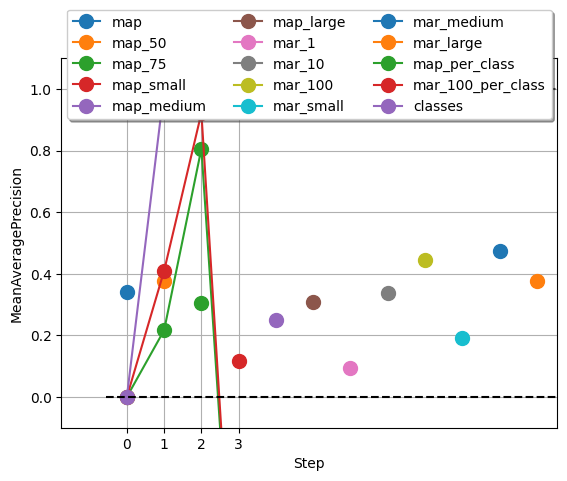

In [ ]:
fig_, ax_ = metric.plot()

In [ ]:
for i in range(len(predicted)):
  visualisePredictions(i, test_dataset, predicted)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
-stop execution-

### Custom Anchor sizes: <a class="anchor" name="custom_anchor"></a>

In [ ]:
#**********************************NEW

# frame of reference
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator

# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),),
#     aspect_ratios=((0.5, 1.0, 2.0),)
# )

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2
# )

# # put the pieces together inside a Faster-RCNN model
# model = FasterRCNN(
#     backbone,
#     num_classes=2,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn

#work around: AttributeError: 'ResNet' object has no attribute 'features'
# backbone = torchvision.models.resnet50(weights="DEFAULT").features
# #https://discuss.pytorch.org/t/change-resnet50s-number-of-output-filters/146644
# backbone.out_channels = 2048

# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

resnet_net = torchvision.models.resnet50(pretrained=True)
modules = list(resnet_net.children())[:-2]
backbone = nn.Sequential(*modules)
backbone.out_channels = 2048

#default
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
anchor_ars = ((0.5, 1.0, 2.0),) * len (anchor_sizes)

anchor_generator = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=anchor_ars
)
# sizes=((16, 32, 64, 128, 256),),
#     aspect_ratios=((0.5, 1.0, 2.0),)


# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2)

#keep default
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"],
                                                output_size=7,
                                                sampling_ratio=2)


model = FasterRCNN(
    backbone,
    num_classes=4,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [ ]:
optimizer = torch.optim.SGD(model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)
num_epochs = 20

## YOLOv11 Implementation: <a class="anchor" name="YOLOv11"></a>

In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from ultralytics import YOLO

In [ ]:
import numpy as np
import random
import torch
#THE SET_SEEDS FUNCTION IS SOURCED FROM:
#https://learnopencv.com/fine-tuning-faster-r-cnn/#aioseo-code-walkthrough
def set_seeds():
  # fix random seeds
  SEED_VALUE = 42
  random.seed(SEED_VALUE)
  np.random. seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)
  if torch.cuda.is_available:
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seeds()

In [ ]:
# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/YOLO_11_w_project_data_second/data.yaml", # path to dataset YAML
    epochs=15, # number of training epochs
    imgsz=640, # training image size
    ) # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu

## Appendix A: <a class="anchor" name="AppenA"></a>
Attempts to override FasterRCNN forward() method

In [ ]:
##***************************************TEST
from torchvision.models.detection import FasterRCNN

import warnings

class ModifiedFasterRCNN(FasterRCNN):
  def forward(self, images, targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        """
        Args:
            images (list[Tensor]): images to be processed
            targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)

        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).

        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        if self.training:
            assert targets is not None
            for target in targets:
                boxes = target["boxes"]
                if isinstance(boxes, torch.Tensor):
                    if len(boxes.shape) != 2 or boxes.shape[-1] != 4:
                        raise ValueError(f"Expected target boxes to be a tensor of shape [N, 4], got {boxes.shape}.")
                else:
                    raise ValueError(f"Expected target boxes to be of type Tensor, got {type(boxes)}.")

        original_image_sizes: List[Tuple[int, int]] = []
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)

        # Check for degenerate boxes
        # TODO: Move this to a function
        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenerate box
                    bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    raise ValueError(
                        "All bounding boxes should have positive height and width."
                        f" Found invalid box {degen_bb} for target at index {target_idx}."
                    )

        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if torch.jit.is_scripting():
            if not self._has_warned:
                warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
                self._has_warned = True
            return losses, detections
        else:
            #MODIFIED THIS LINE
            return losses, detections

from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers, _mobilenet_extractor
from torchvision.ops import misc as misc_nn_ops
from torchvision.models.resnet import resnet50
from torchvision._internally_replaced_utils import load_state_dict_from_url
from torchvision.models.detection._utils import overwrite_eps

model_urls = {
    "fasterrcnn_resnet50_fpn_coco": "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth",
    "fasterrcnn_mobilenet_v3_large_320_fpn_coco": "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth",
    "fasterrcnn_mobilenet_v3_large_fpn_coco": "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth",
}

def modified_fasterrcnn_resnet50_fpn(
    pretrained=False, progress=True, num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs
):
    """
    Constructs a Faster R-CNN model with a ResNet-50-FPN backbone.

    Reference: `"Faster R-CNN: Towards Real-Time Object Detection with
    Region Proposal Networks" <https://arxiv.org/abs/1506.01497>`_.

    The input to the model is expected to be a list of tensors, each of shape ``[C, H, W]``, one for each
    image, and should be in ``0-1`` range. Different images can have different sizes.

    The behavior of the model changes depending if it is in training or evaluation mode.

    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:

        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (``Int64Tensor[N]``): the class label for each ground-truth box

    The model returns a ``Dict[Tensor]`` during training, containing the classification and regression
    losses for both the RPN and the R-CNN.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a ``List[Dict[Tensor]]``, one for each input image. The fields of the ``Dict`` are as
    follows, where ``N`` is the number of detections:

        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (``Int64Tensor[N]``): the predicted labels for each detection
        - scores (``Tensor[N]``): the scores of each detection

    For more details on the output, you may refer to :ref:`instance_seg_output`.

    Faster R-CNN is exportable to ONNX for a fixed batch size with inputs images of fixed size.

    Example::

        >>> model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        >>> # For training
        >>> images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
        >>> boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
        >>> labels = torch.randint(1, 91, (4, 11))
        >>> images = list(image for image in images)
        >>> targets = []
        >>> for i in range(len(images)):
        >>>     d = {}
        >>>     d['boxes'] = boxes[i]
        >>>     d['labels'] = labels[i]
        >>>     targets.append(d)
        >>> output = model(images, targets)
        >>> # For inference
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)
        >>>
        >>> # optionally, if you want to export the model to ONNX:
        >>> torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)

    Args:
        pretrained (bool): If True, returns a model pre-trained on COCO train2017
        progress (bool): If True, displays a progress bar of the download to stderr
        num_classes (int): number of output classes of the model (including the background)
        pretrained_backbone (bool): If True, returns a model with backbone pre-trained on Imagenet
        trainable_backbone_layers (int): number of trainable (not frozen) resnet layers starting from final block.
            Valid values are between 0 and 5, with 5 meaning all backbone layers are trainable. If ``None`` is
            passed (the default) this value is set to 3.
    """
    trainable_backbone_layers = _validate_trainable_layers(
        pretrained or pretrained_backbone, trainable_backbone_layers, 5, 3
    )

    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False

    backbone = resnet50(pretrained=pretrained_backbone, progress=progress, norm_layer=misc_nn_ops.FrozenBatchNorm2d)
    backbone = _resnet_fpn_extractor(backbone, trainable_backbone_layers)
    #MODIFIED THE LINE BELOW
    model = ModifiedFasterRCNN(backbone, num_classes, **kwargs)

    if pretrained:
        state_dict = load_state_dict_from_url(model_urls["fasterrcnn_resnet50_fpn_coco"], progress=progress)
        model.load_state_dict(state_dict)
        overwrite_eps(model, 0.0)
    return model

In [ ]:
#TEST
model = modified_fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

num_classes = 4  #+1 for background - there are 3 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)